<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220914_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 일정 기간 주가 데이터를 이용해 다음날의 종가 예측
 - 알고리즘 : RNN
 - 데이터셋 : 날짜, 시작가, 최고가, 최저가, 거래량
 - 문제유형 : 회귀
 - 평가지표 : 평균제곱 오차

 - 모델이 과거 정보와 현재 정보를 모두 갖고 있어야 함

  > 모델이 내보낸 과거의 출력을 다시 입력으로 사용

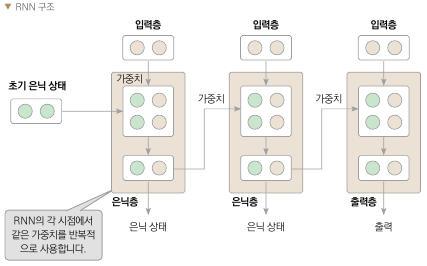

 - 데이터 확인

In [2]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CH06.csv")  # 데이터 파일을 읽어옴
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


 - 입력데이터 : 시작가, 최고가, 최저가
 - 정답데이터 : 종가

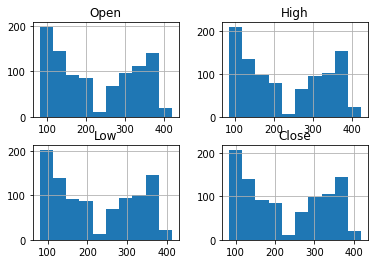

In [4]:
# 데이터의 분포 확인
import matplotlib.pyplot as plt

# data_used = data.iloc[:, 1:4]  # 개장가, 최고가, 최저가 추가
# data_used["Close"] = data["Close"]  # 종가 추가
data_used = data.drop(['Date','Volume'], axis=1)
hist = data_used.hist()
plt.show()

 - 값의 범위가 100-400으로 넓게 형성

  > 출력값의 범위가 커지면 → 오차의 범위 커지고 → 역전파되는 기울기 발산 → 가중치 수렴에 부정적 영향

  > 0-1 사이로 최소-최대 정규화(이상치가 없어야 함)

## 학습용 데이터 만들기
- RNN은 여러 시점의 입력을 받음
- 30일치 데이터를 배치 단위로(경험적 방법)
- 파이토치 제공 데이터셋이 아닌 직접 제작

  > Datset() 객체는 함수 3개 제공 : 오버라이딩 필요
```
__init__() # 데이터셋 초기화
__len__()  # 데이터 개수
__getitem__() # 특정 인덱스의 요소를 불러옴
```



In [15]:
# 넷플릭스 데이터셋 정의
import numpy as np

from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CH06.csv")        # ❷ 데이터 읽기

        # 입력 데이터 정규화
        self.data = self.csv.iloc[:, 1:4].values   # 종가(정답)를 제외한 데이터 → array형식으로
        self.data = self.data / np.max(self.data)  # 0과 1 사이로 정규화(최대값으로 전체 배열을 나눔)

        # 종가 데이터 정규화
        self.label = self.csv['Close'].values         
        self.label = self.label / np.max(self.label)

    def __len__(self):  # 데이터셋의 크기(사용 가능한 배치 개수) → 배치크기는 32으로 향후 지정할 예정
        return len(self.data) - 30 # 전체 967일 데이터를 30일씩(1배치) 묶으면 967-30개의 묶음

    def __getitem__(self, i):   # 인덱스(i) 호출시 해당 인덱스의 data, label 반환
        data = self.data[i:i+30] # 입력 데이터 i부터 i+30일치 미만
        label = self.label[i+30] # 종가 데이터 i+30일 

        return data, label


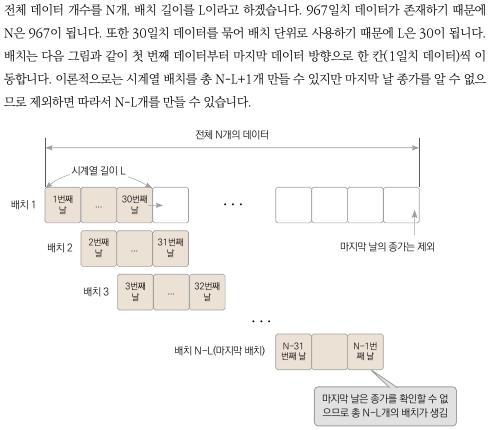

 - 1배치 : 30일간의 데이터
 - 배치크기 : 32(데이터로더 정의시 지정)
 - 데이터의 크기 : 967-30(967일을 하루 간격으로 중복하여 30일씩 묶은 개수)

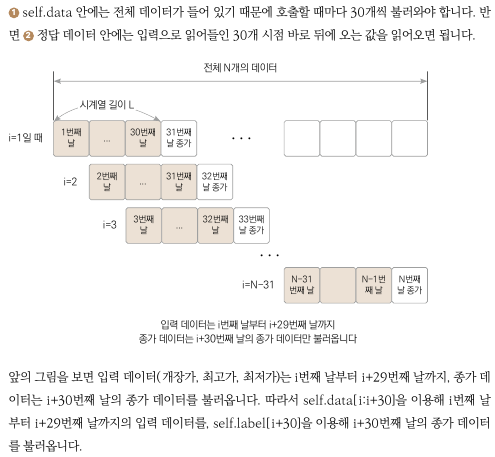

## RNN 모델 정의하기
 - RNN 층을 여러 층 쌓아 **시계열 정보에서 특징 추출**
 - MLP 층을 쌓아 종가를 예측

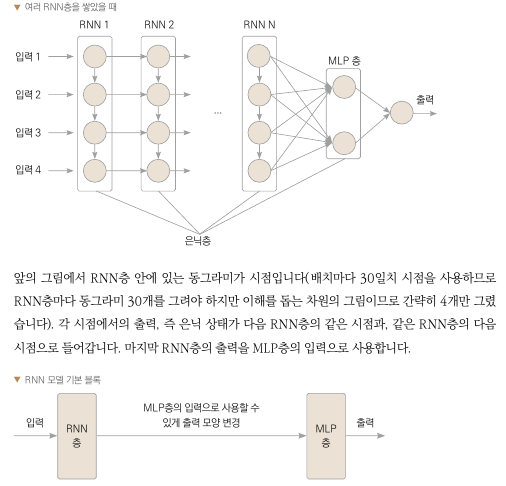

In [6]:
# RNN 클래스 정의하기
import torch
import torch.nn as nn


class RNN(nn.Module):
   def __init__(self):
       super().__init__()

       # RNN층 정의 : 특징을 추출
       self.rnn = nn.RNN(input_size=3,      # 입력텐서의 차원 : feature개수(시작가,최고가,최저가)
                         hidden_size=8,     # 확장할 차원 : 3 → 8 차원(추출할 특징을 늘림)
                         num_layers=5,      # RNN층의 개수(3or5) : 너무크면 기울기소실/발산 우려
                         batch_first=True)  # 배치 차원을 가장 앞으로 : 1배치[30, 3] → 배치크기(32)만큼 쌓음[32, 30, 3]

       # MLP층 정의 : 주가를 예측
       self.fc1 = nn.Linear(in_features=240, out_features=64) # RNN입력[32, 30, 3] → RNN최종출력[32, 30, 8] → MLP입력[32, 240]
       self.fc2 = nn.Linear(in_features=64, out_features=1)   # MLP입력[32, 240] → fc1 → [32, 64] → fc2 → [32, 1]

       # 활성화 함수(층) 정의
       self.relu = nn.ReLU()
        
   def forward(self, x, h0):    # h0 : 모든요소가 0으로 구성된 텐서(초기 은닉 상태), [5(은닉층 개수), 32(배치크기), 8(확장 차원)]
       x, hn = self.rnn(x, h0)  # RNN층의 출력값 두가지

       # MLP층의 입력으로 사용될 수 있도록 모양 변경 : 시계열 차원과 특징 차원을 통합 → 시계열 정보를 반영한 차원으로 확장되는 개념
       #  x = torch.reshape(x, (x.shape[0], -1)) # torch.reshape(tensor, (차원)) 또는 tensor.reshape(차원)
       x = x.reshape(x.shape[0], -1) # 위와 동일한 결과 : [32, 30, 8] → [32, 240]

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
      
       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x) # torch.Size[32] : 1배치(30일간데이터) 마다의 예측값(31일종가)을 확인할 수 있음

       return x

## 모델 학습하기

In [16]:
# 모델 데이터셋 정의
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델 정의
dataset = Netflix() # 데이터셋 정의

In [17]:
# 데이터로더 정의
loader = DataLoader(dataset, batch_size=32)  # 배치 크기를 32로 설정

In [18]:
# 옵티마이저 정의
optim = Adam(params=model.parameters(), lr=0.0001)

In [ ]:
# 학습루프 정의
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       optim.zero_grad()

       # ❶ 초기 은닉 상태
       h0 = torch.zeros(5, data.shape[0], 8).to(device)

       # ❷ 모델의 예측값
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # ❸ 손실의 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

# 모델 성능 평가하기

In [ ]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # ➊초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # ➋예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # ➌손실의 평균치 계산

total_loss.item()

0.0016452015843242407

# 그림으로 확인하기

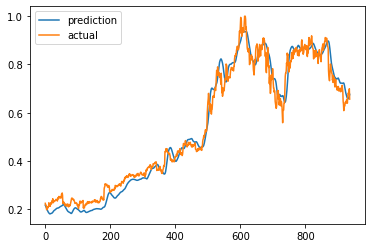

In [ ]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()